In [1]:
import numpy as  np
import scipy.io as  l
import os, sys
top_dir = os.getcwd().split('v4cnn')[0]
sys.path.append(top_dir + 'xarray')
top_dir = top_dir+ 'v4cnn/'
sys.path.append(top_dir)
sys.path.append(top_dir + 'common')
import xarray as xr
import d_misc as dm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline     

<h4>Measuring Translation Invariance</h4>
A well accepted feature of the ventral stream is that it exhibits differing degrees of spatial invariance, it is thought this property allows for some of the invariances neccesary for object perception. Observations of this invariance find that it interacts with the receptive field of a cell. Typically one finds that the pattern of responses remains the same but the responses are scaled as one moves across the receptive field. To understand how this property develops it is important to quantify it in such a way that enables comparisons across diverse cell and stimuli types (i.e. different sized stimuli, receptive field sizes, stimuli selectivity).

There are two avenues we try towards this measure:

1. Measure a cells fit to a model of translation invariance with interpretable coefficients, here we use the singular value decomposition, and normalizations of this measure.

2. Measure directly the similarity between responses at different positions, here we use covariance.

We assume a unit has been stimulated with $m$ shapes, at $n$ positions where typically $m \geq n$. This gives us an $m \ x \ n$ matrix of responses $R$.
We model $R$ as the outer product of a receptive field $\vec{f}$, and  stimuli response profile $\vec{s}$. 
$$ \hat{R} = \vec{f} \otimes \vec{s} $$
We do this by performing the singular value decomposition of $R$:
$$ R = U \Sigma V $$

$U$ is $m \ x \ n$, its columns are eigenvectors of $R$, and the 1st column is the least squares estimate of $\vec{s}$.

V is $n \ x \ n$, its rows are eigenvectors of $R$, and the first column is a least squares estimate of $\vec{f}$.

$\Sigma$ is an $n \ x \ n$ scaling matrix where $\Sigma_{ii}=\sigma_i$ are the sorted singular values of $R$, and $\sigma_1$ is the smallest possible value of  $\sqrt{ \sum  (R - \vec{f} \otimes \vec{s})^2}$

Finally we take as our measure of fit to the TI model what we will call TIA:
$$\frac{\sigma_1^2}{\sum \sigma_i^2}$$

In [2]:
def measure_TIA_array(unit):
    s = np.linalg.svd(unit, compute_uv=False)
    return (s[0]**2)/sum(s**2)

Lets get some intuition for how this method works:

Response Matrix:
[[ 1.   0.7]
 [ 0.8  0. ]]


/Users/dean/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


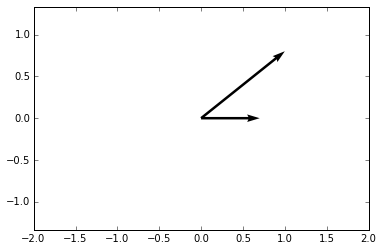

In [3]:
r = np.array([[1, 0.7],[.8, 0]])
print('Response Matrix:')

print(r)
plt.figure()
_ = plt.quiver(0,0,r[0,:],r[1,:],angles='xy',scale_units='xy',scale=1)
plt.axis('equal');plt.xlim(-2,2);plt.ylim(-2,2);

Here we have a response matrix with shapes along rows, and position along columns. The geometric picture of this situation is shown below, where we see two orthogonal vectors.

Our estimated stimuli profile
[[ 0.86]
 [ 0.52]]
Our estimated receptive field
[ 0.9   0.43]
Our singular values
[ 1.4  0.4]
Our estimated TI response
[[ 1.09  0.51]
 [ 0.65  0.31]]


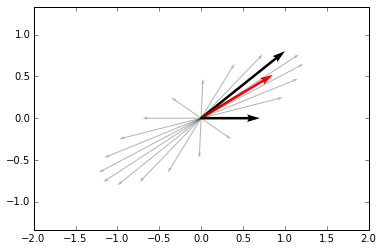

In [4]:
pi = np.pi;theta = np.linspace(0,2*pi-2*pi/20.,20)
circle = np.array([np.cos(theta), np.sin(theta)]).T
res = np.dot(circle, r.T)
_ = plt.quiver(0,0,r[0,:],r[1,:],angles='xy',
               scale_units='xy',scale=1)
u,s,v = np.linalg.svd(r)
_ = plt.quiver(0,0, -u[0,0], -u[1,0],angles='xy',
               scale_units='xy',scale=1, color='r')
_ = plt.quiver(0,0, res[:,0], res[:,1], alpha=0.3,
               angles='xy',scale_units='xy',scale=1, color='k', width=0.003)
plt.axis('equal');plt.xlim(-2,2);plt.ylim(-2,2);
print('Our estimated stimuli profile');print(np.round(-u[:,0].reshape(2,1),2))
print('Our estimated receptive field');print(np.round(-v[0,:],2))
print('Our singular values');print(np.round(s,2))
print('Our estimated TI response');print(np.round(np.dot(u[:,0].reshape(2,1), v[0,:].reshape(1,2))*s[0],2)) 

In black we have the columns of $R$ , in red we have our estimated stimuli profile vector, <font color='red'> $ \vec{s}$</font>.

We can get some sense for what is special about $\vec{s}$, by looking at the grey arrows, which are the result of taking a unit vector and seeing at many different directions how much it covaried with our response vectors, as shown by their length. 

You can see as it comes to point somewhere in the middle of the two response vectors, covariance is maximal, and this direction is $\vec{s}$.



[]

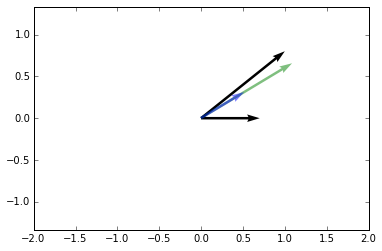

In [5]:
_ = plt.quiver(0,0,r[0,:],r[1,:],angles='xy',
               scale_units='xy',scale=1)
u,s,v = np.linalg.svd(r)
rhat = np.dot(u[:,0].reshape(2,1), v[0,:].reshape(1,2))*s[0]
_ = plt.quiver(0,0, rhat[0,0], rhat[1,0],angles='xy',
               scale_units='xy',scale=1, color='g', alpha=0.5)
_ = plt.quiver(0,0, rhat[0,1], rhat[1,1],angles='xy',
               scale_units='xy',scale=1, color='b',alpha=0.5)
plt.axis('equal');plt.xlim(-2,2);plt.ylim(-2,2);
plt.plot()


Our estimated receptive field,  $ \ \vec{f}$, scales $\vec{s}$ to best fit each column of $R$. In blue you see the scaling of $\vec{s}$ to match the smaller response, and in green you see its scaling for the larger response pointing to the upper-right.

<h4>Negative receptive field profiles</h4>
One final issue that should be taken into account is responses that are negatively correlated.

Response Matrix:
[[ 1.  -0.7]
 [ 0.8  0. ]]
Our estimated stimuli profile
[[ 0.85707503]
 [ 0.5151916 ]]
Our estimated receptive field
[ 0.90408501 -0.42735265]
Our singular values
[ 1.4038816   0.39889404]
Our estimated TI response
[[ 1.0878239  -0.51420433]
 [ 0.65389577 -0.3090905 ]]


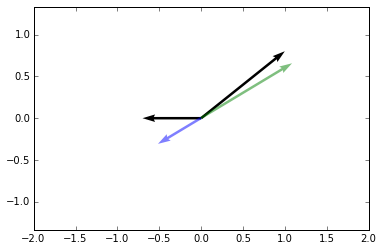

In [6]:
r = np.array([[1, -0.7],[.8, 0]])
print('Response Matrix:');print(r)
_ = plt.quiver(0,0,r[0,:],r[1,:],angles='xy',
               scale_units='xy',scale=1)
u,s,v = np.linalg.svd(r)
rhat = np.dot(u[:,0].reshape(2,1), v[0,:].reshape(1,2))*s[0]
_ = plt.quiver(0,0, rhat[0,0], rhat[1,0],angles='xy',
               scale_units='xy',scale=1, color='g', alpha=0.5)
_ = plt.quiver(0,0, rhat[0,1], rhat[1,1],angles='xy',
               scale_units='xy',scale=1, color='b',alpha=0.5)
plt.axis('equal');plt.xlim(-2,2);plt.ylim(-2,2);
plt.plot()
print('Our estimated stimuli profile');print(-u[:,0].reshape(2,1))
print('Our estimated receptive field');print(-v[0,:])
print('Our singular values');print(s)
print('Our estimated TI response');print(np.dot(u[:,0].reshape(2,1), v[0,:].reshape(1,2))*s[0])

Even though our two responses are actually anti-correlated SVD simply makes a portion of our receptive field negative to capture that variance. Intuitively this seems wrong as a cell that has the opposite response to stimuli at one position is not maintaining an invariant representation of those stimuli. 

One way to correct for this is to restrict our SVD to the subset of $R$'s columns with the highest non-negative covariance $R_+$. We will of course include the error resulting from those responses outside of this subset $R_-$.
$$ \sqrt{ \sum (R_+ - \vec{f}_+ \otimes \vec{s}_+)^2} + \sum (R_-)^2$$ 

Finding this subset for large n may be non trivial as the number of possible subset is $2^n$. Albeit in a typical electrophysiological experiment n will be small.

<h4>To mean substract or not?</h4>
The entries of $R$ for a neurons responses are non-negative, thus for the raw data all of our vectors covariance will be non-negative. 
Except for some scaling of the identity matrix, the columns of positive matrices get pushed closer to each other around the direction of the mean vector $\vec{\mu}_i = \frac{1}{\sqrt{m}}$. 

For a positive distribution the variance is bounded by the mean and $\vec{s}$ thus has a tendency towards $\vec{\mu} $ trivially inflating our TIA metric. We are interested whether a pattern of responses was maintained not the magnitude of $\frac{\mu}{\sigma^2}$ for our columns.

<h3>TI irrelevant dependencies of TIA</h3>
Unfortunately as we will see TIA is dependent on factors the are irrelevant to TI such as number of positions or stimuli, receptive field size, and stimuli selectivity. Below we will try our best to deal with these issues.
<h4>TIA depends on the number of positions measured.</h4>
For example if we take a response that has no translation invariance, i.e. each column is orthogonal TIA will not give it a score of 0.

In [7]:
unit = np.eye(5)*2
print(unit)
print('TIA = ' + str(measure_TIA_array(unit)))

[[ 2.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  2.]]
TIA = 0.2


It instead gives TIA of 0.2, why is this?

In [8]:
print('The singular values of our unit:')
print(np.linalg.svd(unit, compute_uv=False))

The singular values of our unit:
[ 2.  2.  2.  2.  2.]


Because the SVD guarantees only that $$\sigma_1 \ge \dots \ge \sigma_n$$ and in the above case $$\sigma_1 = \dots = \sigma_n$$ thus $$\frac{\sigma_1^2}{\sum \sigma_i^2} = \frac{1}{n}$$ where $n$ is the number of positions. This is uniquely the case where all columns of our matrix have equal length and are orthogonal.
In this case $TIA>=\frac{1}{n}$ thus TIA depends on the number of positions measured which is irrelevant to TI.

To correct for this in general we can try to figure out, for the type of matrices we are dealing with, what $F$ is where $TIA>=F$

Then we get a normalized value $$TIN = \frac{TIA-F}{(1-F)}$$

If for example we take $F = \frac{1}{n}$ we are guranteed that TIN over all possible response matrices will range between 0, and 1. Lets check for our previous matrix: 

In [9]:
unit = np.eye(5)
TIA = measure_TIA_array(unit)
F = 1./len(unit[:,])
TIN = (TIA-F)/((1-F))
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))

TIA = 0.2
TIN = 0.0


Great! 
Our ideal goal for TIN will be to make a comparison between response matrices of different RF and SP, such that a particular RF or SP doesn't advantage one cell over another, and when making a comparison we can assign some confidence to the amount of TI that resulted from trial to trial variation, and that deriving from the expected value of the response. 

Ideally we would know the distribution of TIA for IID noise under the constraint of a RF and SP, then assign some confidence to the likelihood of a difference in TI between two cells of differing RF and SP.

For now we will potentially incorrectly assume that the distribution of TIA for IID noise with some RF and SP  are simple rescalings of each other, thus scaling our distribution between F and 1 equates the two distributions of TIN.
In reality our distribution is probably more akin to an F-distribution.
In other words given an RF and SF we want the F that is the minimal possible TI.

<h4>Non-Uniform RF</h4>

While $F = \frac{1}{n}$ works in the previous case lets look at the case where we know our matrix does not have column vectors of equal length i.e. a non-uniform RF. Here we are essentially trying to remove receptive field size as a factor in TI i.e. just because two cells have different RF sizes, doesn't mean one should get better TI:

In [10]:
unit = np.zeros((4,4))
unit[:,1] = 1
unit[:,2] = [1,-1,1,-1]

print('Unit responses:')
print(unit)
print('RF:')
print(np.sum(unit**2,0))

Unit responses:
[[ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]]
RF:
[ 0.  4.  4.  0.]


In this case the cell has a non-uniform RF.

Keep in mind again the columns are orthogonal so intuitively we should expect a translation invariance of 0.

What is our measure of TIA and TIN where $F = \frac{1}{n}$, for this response matrix?

In [11]:
TIA = measure_TIA_array(unit)
F = 1./len(unit[:,])
print('F=' + str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False))

F=0.25
TIA = 0.5
TIN = 0.333333333333
The singular values=
[ 2.  2.  0.  0.]


Terrible! It seems a non-translation invariant cell can take on translation invariance simply with a non-uniform receptive field, in this case a compact receptive field. 

Even if our columns are orthogonal $\sigma_1$ will simply equal the magnitude of the greatest response position, or the center of the RF.

In the case of all response matrices with non-uniform RF's what F do we need?
$$F = \frac{max_i(\sum\limits_{j=1}^m R_{i,j}^2)}{\sum\limits_{i,j}^{m,n} R_{i,j}^2}$$

The variance of the position with the greatest variance divided by the total variance. 

Lets see how it works:

In [12]:
print(unit)
TIA = measure_TIA_array(unit)
F = max(np.sum(unit**2,0))/np.sum(unit**2)
TIN = (TIA-F)/(1-F)
print('F= ' +str(F))
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))


[[ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]]
F= 0.5
TIA = 0.5
TIN = 2.22044604925e-16


Nice! The intuition behind this correction is that if we only know the length of each column vector, the direction of those vectors is still free to vary. With direction freely varying but length fixed vectors, what is the minimal singular value they could take on? It is the case where all columns are orthogonal to each other, and in this case the principal component will take on the direction of the longest vector, and will account for only its variance (because all other columns are orthogonal to it).
Now lets try to add on one more constraint the SR

Above I demonstrated this inuition where in red I show the two vectors composing my orthogonal response matrix with a non-uniform RF, and in blue I show the covariance (w/out mean subtracted) for unit vectors at the same angle as the blue with reference to the black, clearly the most covariance is to be found in the direction of the longest vector in my orthogonal matrix. The direction of my longest vector does in fact become my 1st estimated stimuli profile, and it is scaled exactly by its length.

<h4>Non-uniform SP</h4>
Now lets see what happens when our SP constrains the dimensionality of our matrix, this reflects the possible case where our unit only responds strongly to a subset of the stimuli.

In [13]:
unit = np.zeros((3,3))
unit[0,0] = 1;unit[1,1] = 0.5**0.5;unit[0,1] = 0.5**0.5;unit[1,2] = 1

print('Unit responses:')
print(unit)
print('RF:')
print(np.sum(unit**2, 0))
print('SP')
print(np.sum(unit**2, 1))

Unit responses:
[[ 1.          0.70710678  0.        ]
 [ 0.          0.70710678  1.        ]
 [ 0.          0.          0.        ]]
RF:
[ 1.  1.  1.]
SP
[ 1.5  1.5  0. ]


In [14]:
TIA = measure_TIA_array(unit)
F = np.max([np.sum(unit**2,0)])/np.sum(unit**2)
print('F='+str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False)**2)      

F=0.333333333333
TIA = 0.666666666667
TIN = 0.5
The singular values=
[ 2.  1.  0.]


Our original motivation for F was that it would take on the minimal value a class of matrices under study could take. In this case we are studying matrices with a particular RF and SP. For this matrix I posit for this RF and SP is the minimal possible value TIA can take on (for this dimensionality this is the lowest covariance two vectors orthogonal and one 45 degrees from both), which as you can see is .66, yet F is calculated as 0.33. 

We run into a problem attempting to find what F in general should be... when we know the RF, we fully determine the length of our column vectors, and the information from the SP constrains their direction. In the above case the compact SP constrains our column vectors to only point along the first two dimensions. Thus our assumption of orthogonality gives a much lower min TIA, then is actually the case.

Our trick before was to find the minimal value of TIA by assuming orthogonality of our column vectors, but for some SF's this is not possible. Determining the minimal TIA for vectors that are not correlated, amounts to finding the arrangement of vectors with an RF and SP that minimizes R's covariance. 

One way around this is to assume we can achieve orthogonality and follow this assumption to its logical conclusion given our knowledge of the RF and SP. 

Lets start with the fact that $A$ and $A^T$ have the same singular values:

In [15]:
a = np.random.normal(size=[10,5])
u,s,v = np.linalg.svd(a);print(s)
u,s,v = np.linalg.svd(a.T);print(s)

[ 4.8941688   3.83006661  2.2749054   1.96671381  1.23424692]
[ 4.8941688   3.83006661  2.2749054   1.96671381  1.23424692]


keeping the fantasy of orthogonality in mind we look at $A$ and $A^T$ and know the greatest singular value will be the highest variance of the columns of either. 

$$F = \frac{max(max_i(\sum\limits_{j=1}^m \ R_{i,j}^2),max_j(\sum\limits_{i=1}^n R_{i,j}^2))}{\sum\limits_{i,j}^{m,n} R_{i,j}^2}$$

Keep in mind this gives a potentially conservative estimate of TIA as for some RF and SP's their forced correlation could make their floor TI much higher. Lets see how it works

In [16]:
unit = np.zeros((3,3));unit[0,0] = 1;unit[1,1] = 0.5**0.5;unit[0,1] = 0.5**0.5;unit[1,2] = 1
TIA = measure_TIA_array(unit)
F = np.max([np.sum(unit**2,0),np.sum(unit**2,1)])/np.sum(unit**2)
print(unit)
print('F='+str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False)**2)   

[[ 1.          0.70710678  0.        ]
 [ 0.          0.70710678  1.        ]
 [ 0.          0.          0.        ]]
F=0.5
TIA = 0.666666666667
TIN = 0.333333333333
The singular values=
[ 2.  1.  0.]


Here we see our F gets closer to the true F (in this case TIA) but doesn't quite make it. Thus our current F as it is will give preference to units with sparser responses over shapes.
Another way is to estimate F, we randomly draw from vectors with the RF and SP, then take the minimal TIA. 
One initial try might be to permute the columns, then take the mean, or min as our F.

In [17]:
def permute_unit(unit):
    unit = unit.dropna('x', 'all').dropna('shapes', 'all')
    for x in range(len(unit.coords['x'])):
        unit[x,:] = np.random.permutation(unit[x,:].values)
    return unit 
def permute_unit_array(unit):
    for x in range(np.shape(unit)[1]):
        unit[:,x] = np.random.permutation(unit[:,x])
    return unit

unit = np.zeros((3,3));unit[0,0] = 1;unit[1,1] = 0.5**0.5;unit[0,1] = 0.5**0.5;unit[1,2] = 1
n_permute = 1000
tias = []
print(unit)
for ind in range(n_permute):
    tias.append(measure_TIA_array(permute_unit_array(unit)))
print('F estimate min(TIAS) :' + str(min(tias)))
print('F estimate mean(TIAS) :' + str(np.mean(tias)))
print('F estimate median(TIAS) :' + str(np.median(tias)))
unit[:,:] = 0
unit[1,:] = 1
print(unit)
for ind in range(n_permute):
    tias.append(measure_TIA_array(permute_unit_array(unit)))
print('F estimate min(TIAS) :' + str(min(tias)))
print('F estimate mean(TIAS) :' + str(np.mean(tias)))
print('F estimate median(TIAS) :' + str(np.median(tias)))

[[ 1.          0.70710678  0.        ]
 [ 0.          0.70710678  1.        ]
 [ 0.          0.          0.        ]]
F estimate min(TIAS) :0.569035593729
F estimate mean(TIAS) :0.674181770322
F estimate median(TIAS) :0.666666666667
[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 0.  0.  0.]]
F estimate min(TIAS) :0.333333333333
F estimate mean(TIAS) :0.646924218494
F estimate median(TIAS) :0.666666666667


Uh oh! First of all our min sampled TIA, is lower than the true minimal TIA, and our mean TIA is higher but our median is actually perfect but this is an artifiact. As you can see I try the same procedure on anothe response, and get nowhere near the true F, which is in both cases because shuffling changes the dimensionality of my matrix.
So what to do!? I'm not sure, to estimate stochastically we need to draw from matrices that satisfy the SP and RF (the simplest way would be to randomly flip signs, but this doesn't draw from all possible matrics). And to find F otherwise we need a method that finds the matrix with the same RF and SF that minimizes covariance, unfortunately the equation we must satisfy is a sum of squared entries in our matrix, so is undetermined, i.e. each entry could have been positive or negative, and still satisfy the equation.

<h4>Alternative measures of TI</h4>
Another option is to give up on an explicitly fit model of TI:
$$ R = \vec{f} \otimes \vec{s} $$
We are in the end trying to measure covariance of responses by position, in our TIA measure we evaluated this by finding how well we could explain all of our variance with a single vector, another way we could go about it is by finding the total covariance and scaling it by the total possible covariance. 

$$\frac{\sum\limits_{i,j \in i \neq j} \vec{x}_{i} \vec{x}_{j}^T }{\sum\limits_{i,j \in i \neq j} || \vec{x}_{i} || \ || \vec{x}_{j} ||}$$

This will have a couple nice properties, if the columns are orthogonal then it will give us zero. Thus it solves all our problems up to Non-Uniform RF, but in the cases where the direction of our column vectors becomes constrained it does not easily provide a solution.

In [18]:
def norm_av_cov(unit, return_num_den=False):
    cov = np.dot(unit.T, unit)
    cov[np.diag_indices_from(cov)] = 0
    numerator = np.sum(np.triu(cov))
    vlength = np.linalg.norm(unit, axis=0)
    max_cov = np.outer(vlength.T, vlength)
    max_cov[np.diag_indices_from(max_cov)] = 0
    denominator= np.sum(np.triu(max_cov))
    if return_num_den:
        return numerator, denominator
    else:
        return numerator/denominator
units = []
unit = np.zeros((4,4));unit[:,1] = 1;unit[:,2] = [1,-1,1,-1]  
units.append(unit) 
unit = np.zeros((4,4));unit[:,1] = 1;unit[:,2] = 4
units.append(unit) 
unit = np.zeros((4,4));unit[0,0] = 1;unit[1,1] = 0.5**0.5;unit[0,1] = 0.5**0.5;unit[1,2] = 1
units.append(unit) 

for unit in units:
    numerator, denominator = norm_av_cov(unit, return_num_den=True)
    print(unit)
    print('total covariance: ' + str(numerator))
    print('total possible covariance: ' + str(denominator))
    print('normalized average covariance: ' + str(numerator/denominator))


[[ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]]
total covariance: 0.0
total possible covariance: 4.0
normalized average covariance: 0.0
[[ 0.  1.  4.  0.]
 [ 0.  1.  4.  0.]
 [ 0.  1.  4.  0.]
 [ 0.  1.  4.  0.]]
total covariance: 16.0
total possible covariance: 16.0
normalized average covariance: 1.0
[[ 1.          0.70710678  0.          0.        ]
 [ 0.          0.70710678  1.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
total covariance: 1.41421356237
total possible covariance: 3.0
normalized average covariance: 0.471404520791


In the first case we can see it avoids the problem of receptive field size. In the second case we see the method works to detect perfect translation invariance, but in the third case we see it does not avoid the problem of taking into account stimuli profiles where covariance is unavoidable.

<h4>Geometric interpretation of the core issue with disentangling TI and SP</h4>
Our fundamental problem is we are unable to confidently disentangle whether something is more TI because the cell is more invariant, or because only a small subset of the stimuli we chose drove the stimuli well. In geometric terms, when there is a non-uniform SP the direction of our responses is not homoschedastic, i.e. some entries of our columns have higher variance than others, and thus they are heteroschedastic favoring some directions over others. When some directions are apriori favored over others they will tend to be more correlated then their homoscedastic counterparts.


In [19]:
def calc_tia_over_units(units):
    da_units = xr.DataArray(units, dims=['unit', 'shapes', 'x'])
    return np.array([measure_TIA(unit) for unit in da_units])
    

top_scale = [0.1,2.,4]
for scale in top_scale:
    units = np.random.normal(size=(100, 10, 5))*np.linspace(.1,scale,10).reshape((1,10,1))
    tia = calc_tia_over_units(units)
    av_cov = np.mean([norm_av_cov(unit) for unit in units])
    plt.figure()
    plt.subplot(121);plt.imshow(units[1,...], interpolation='nearest');
    plt.title('homoscedastic sample')
    plt.subplot(122);plt.plot((np.var(units,(0,2))**0.5), range(10));plt.ylim(9, 0);plt.xlim(0,10)
    plt.ylabel('Shape');plt.xlabel('SD');plt.title('Mean tia: '+ str(np.round(np.mean(tia),3))
                                              + ' Mean av_cov: ' + str(np.round(av_cov,5)))


NameError: global name 'measure_TIA' is not defined

Here it would seem mean av_cov is not influenced by heteroscedascity like TIA, and the reason is because this heteroscedascity is symmetric! IF we can assume for a given RF and SF that it is heteroschedastically symmetric then av_cov will on average not give an advantage to any particular profile.

<h4>Best possible and worst possible TI units</h4>
Here I am making two artificial units, min_ti has 0 translation invariance, it is a fourier basis, and max_ti_unit that is just the same response over position.

In [ ]:
min_ti_unit = np.concatenate([np.imag(np.fft.rfft(np.eye(5)))[:,1:], np.real(np.fft.rfft(np.eye(5)))[:,1:]], axis =1)
min_ti_unit = np.concatenate([min_ti_unit, np.zeros((51,4))])
the_nans = (np.nan*np.ones((np.shape(min_ti_unit)[0],1)))
min_ti_unit = np.concatenate([min_ti_unit, the_nans], 1)
max_ti_unit = np.tile(min_ti_unit[:,0],(5,1)).T
min_ti_unit = np.expand_dims(min_ti_unit.T, 0)
min_ti_unit = xr.DataArray(min_ti_unit, dims=['unit','x','shapes'])
max_ti_unit = np.expand_dims(max_ti_unit.T, 0)
max_ti_unit = xr.DataArray(max_ti_unit, dims=['unit','x','shapes'])

Here we can look at the values of these pathological cells, here rows are positions, and columns 'shapes'. Note the first just has the same response over each position, and the second has an orthogonal basis function of first sines then cosines. In this case the cells only respond to the first couple shapes.

In [ ]:
print('Perfect TI')
print(np.round(max_ti_unit[0,:,:10],3).values)
print('Perfectly terrible TI')
print(np.round(min_ti_unit[0,:4,:10],3).values)

Now lets load up the V4 cells, and concatenate them with our artificial cells at the top of the unit by position by shape stack

In [ ]:
fn = top_dir +'data/responses/v4_ti_resp.nc'
v4 = xr.open_dataset(fn)['resp'].load()

v4 = v4.transpose('unit', 'x', 'shapes') 


Lets look at the histogram of responses for the V4 cells.

In [ ]:
all_v4 = v4.values.ravel()
all_v4 = all_v4[~np.isnan(all_v4)]
_ = plt.hist(all_v4,log=True, bins=100);plt.xlabel('Firing Rate');plt.ylabel('Count')

Looks good, seem to be the raw responses, without the mean subtracted.
Now lets tack our pathological cells on to the V4 data set, and subtract the mean of the shapes at each position.

In [ ]:
v4 = xr.concat([min_ti_unit, max_ti_unit, v4], dim='unit')
v4 = v4 - v4.mean('shapes')

In [ ]:
def measure_TIA(unit, return_uv=False):
    unit = unit.dropna('x', 'all').dropna('shapes', 'all')
    unit = unit.transpose('shapes','x')
    if return_uv:
        u,s,v = np.linalg.svd(unit.values, compute_uv=True)
        return (s[0]**2)/np.sum(s**2), u , s,  v
    else:
        s = np.linalg.svd(unit.values, compute_uv=False)
        return (s[0]**2)/np.sum(s**2)
    
def norm_av_cov(unit, return_num_den=False):
    unit = unit.transpose('shapes','x')
    unit = unit.dropna('x', 'all').dropna('shapes', 'all').values
    cov = np.dot(unit.T, unit)
    cov[np.diag_indices_from(cov)] = 0
    numerator = np.sum(np.triu(cov))
    vlength = np.linalg.norm(unit, axis=0)
    max_cov = np.outer(vlength.T, vlength)
    max_cov[np.diag_indices_from(max_cov)] = 0
    denominator= np.sum(np.triu(max_cov))
    if return_num_den:
        return numerator, denominator
    else:
        return numerator/denominator

In [ ]:
av_cov = np.array([norm_av_cov(unit) for unit in v4])
#f = 0
tia = np.array([measure_TIA(unit) for unit in v4])
#f = 1/n_x
n_x = np.array([cell.dropna('x', 'all').dropna('shapes', 'all').shape[0] for cell in v4])
f = 1./n_x
tin_f_nx = (tia-f)/(1-f)
#f = max(rf)/tot_var
max_rf_var = (v4.dropna('x', 'all')**2).sum('shapes').max('x')
tot_var = (v4**2).sum(['shapes','x'])
f = (max_rf_var/tot_var).values
tin_f_maxrf = (tia-f)/(1-f)
#f = max(max(rf), max(sf))
max_rf_var = (v4.dropna('x', 'all')**2).sum('shapes').max('x')
max_srf_var = (v4.dropna('shapes', 'all')**2).sum('x').max('shapes')
max_both = xr.concat([max_rf_var,max_srf_var], dim='c').max('c')
f = max_both/tot_var
tin_f_max_rf_srf = ((tia-f)/(1-f)).values
#f = mean(TI(cell resp permuted))
n_perms = 20
tias_mean = [] 
tias_min = [] 
for unit in v4:
     unit = unit.dropna('x', 'all').dropna('shapes', 'all')
     all_perm_tia = [measure_TIA(permute_unit(unit)) for ind in range(n_perms)]
     tias_mean.append(np.mean(all_perm_tia))
     tias_min.append(np.min(all_perm_tia))

f = np.array(tias_mean)
tin_f_tias_mean = (tia-f)/(1-f)

f = np.array(tias_min)
tin_f_tias_min = (tia-f)/(1-f)

tins_lst = np.array([av_cov, tia, tin_f_nx, tin_f_maxrf, tin_f_max_rf_srf, tin_f_tias_min, tin_f_tias_mean]).T
tins_nm = ['av_cov', 'tia', 'nx', 'maxrf', 'max_rf&srf', 'tias_min', 'tias_mean']
tins = pd.DataFrame(tins_lst, columns=tins_nm)

from pandas.tools.plotting import scatter_matrix
axes = scatter_matrix(tins[2:], alpha=1, figsize=(12, 12),s=5, color='r')
for i, axes1 in enumerate(axes):
    for j, ax in enumerate(axes1):
        if i!=j:
            ax.plot([-1,1],[-1,1], alpha=0.6, color='k');
            ax.plot([-1,1],[0,0],alpha=0.6, color='k');
            ax.plot([0,0], [-1,1],alpha=0.6, color='k');

            ax.set_xlim(-0.2,1.1);ax.set_ylim(-0.2,1.1);
            ax.scatter(tins.loc[:1].values[:,j],tins.loc[0:1].values[:,i], color=['b','g'], s=5)
        else:
            ax.set_xlim(-0.2,1.1);            
_ = plt.tight_layout()
_=plt.show()


At a glance it would seem F=1/n doesn't do much, max rf does about the same as anyting else, except dividing max rf and sf seems to change the value of one of our cells a little bit. 
One problem we quickly note is that using TIAs mean does give us a negative value for our perfectly translation invariant unit.
Now our worse fear is that our TI is mainly being driven by units that are sparse over shape. Let look at real units and see if we can find at least a correlation to support this.

In [ ]:
def kurtosis(da):
    da = da.dropna('shapes')
    da = da.transpose('shapes','unit')
    mu = da.mean('shapes')
    sig = da.reduce(np.nanvar, dim='shapes')
    k = (((da - mu)**4).sum('shapes',skipna=True)/da.shapes.shape[0])/(sig**2)
    return k
#lets find kurtosis of our SP
fn = top_dir +'data/responses/v4_ti_resp.nc'
v4 = xr.open_dataset(fn)['resp'].load()
v4 = v4.transpose('unit', 'x', 'shapes') 
v4 = v4 - v4.mean('shapes')
sp = v4.var('x')
k = kurtosis(sp)

#f = 0
tia = np.array([measure_TIA(unit) for unit in v4])
max_rf_var = (v4.dropna('x', 'all')**2).sum('shapes').max('x')
tot_var = (v4**2).sum(['shapes','x'])
f = (max_rf_var/tot_var).values
tin_f_maxrf = (tia-f)/(1-f)
print(sp.shape)
print(tin_f_maxrf.shape)
plt.scatter(k, tia);plt.ylim(0,1);plt.ylabel('tia');plt.xlabel('k');
print('r = ' +  str(np.corrcoef([k,tia])[0,1]))

plt.figure()
plt.scatter(k, tin_f_maxrf);plt.ylim(0,1);plt.ylabel('tin f=max_rf_var');plt.xlabel('k');
print('r = ' +  str(np.corrcoef([k,tin_f_maxrf])[0,1]))

av_cov = np.array([norm_av_cov(unit) for unit in v4])
plt.figure()
plt.scatter(k, tin_f_maxrf);plt.ylim(0,1);plt.ylabel('tin f=max_rf_var');plt.xlabel('k');
print('r = ' +  str(np.corrcoef([k, av_cov])[0,1]))

There is some correlation which either means sparser units tend to be more TI, or sparser units are biased to have a higher TIN.

Lets look at the individual plots:

In [ ]:
for ti_in in np.argsort(tin_f_maxrf)[-50::1]:
    plt.figure(figsize=(10,2))
    plt.imshow(v4[ti_in].dropna('x', 'all').dropna('shapes', 'all'), interpolation='nearest')
    plt.colorbar()
    plt.title('tin = ' + str(np.round(tin_f_maxrf[ti_in],3)) + ' k = '
              + str(np.round(k[ti_in].values, 3)))
    plt.xlabel('shape');plt.ylabel('pos')
    
    tia, u,s, v = measure_TIA(v4[ti_in], return_uv=True)
    plt.figure(figsize=(10,2))
    plt.imshow(s[0]*np.dot(u[:,0].reshape(len(u),1), v[0,:].reshape(1,len(v))).T,
               interpolation='nearest')
    plt.colorbar()
    plt.title('R estimate')
    plt.xlabel('shape');plt.ylabel('pos')
    plt.figure(figsize=(6,2))
    plt.subplot(121);plt.plot(u[:,0]);plt.xlabel('shape');plt.ylabel('SP')
    plt.subplot(122);plt.plot(v[0,:]*s[0]);plt.xlabel('pos');plt.ylabel('RF');plt.tight_layout()
    